# NLP Project: Sentiment Analysis

-------------------------------------------------------------------------------------
Nom: Rouis Ibrahim

Goupe: 5GL B

Sous Groupe 2

-------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import csv
import requests
import textwrap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Define model
The model we are using is [granite3.3:2b](https://ollama.com/library/granite3.3) which isrunning on localhost thanks to [Ollama](https://ollama.com/)

Ollama is the easiest way to get up and running with large language models such as granite3.3, gpt-oss, Gemma 3, DeepSeek-R1, Qwen3 and more.

The IBM Granite 2B models is 128K context length language models that have been fine-tuned for improved reasoning and instruction-following capabilities.

Granite 3.3 is a decoder‑only transformer language model

In [2]:
OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "granite3.3:cpu"

## Load reviews.csv
The reviews.csv file is a collection of reviews written by customer to Restaurants.

All public reviews are collected by myself from [yelp](https://www.yelp.com/).

It contains two columns: `text` and `sentiment`.

In [3]:
df = pd.read_csv("reviews.csv", encoding="cp1252")
df.head()


,text,sentiment
0,"The food was incredible. Not only did Nomi, ou...",Positive
1,This was my first time eating at Fog Harbor Fi...,Positive
2,We had reservations here on a Saturday night w...,Positive
3,While the setting is magical and its decked ou...,Negative
4,Plenty of sourdough rolls. Near the end of the...,Positive


## Average review size

In [4]:
# Avrage review size
total_length = sum(len(str(review)) for review in df['text'])
average_length = total_length / len(df)
print(f"Average review length: {average_length:.2f} characters")

Average review length: 697.21 characters


## Define sentiment analysis functions

In [5]:
# Function to analyze sentiment using the local LLM
def analyze_sentiment(text) -> str:
    try:
        prompt = f"Respond exactly with one word: Positive or Negative.\nText:\n{text}"
        payload = {"model": MODEL_NAME, "prompt": prompt, "stream": False}
        response = requests.post(OLLAMA_URL, json=payload)
        response.raise_for_status()
        result = response.json()
        # Extract the generated sentiment
        return result.get("response", "").strip()
    except requests.RequestException as e:
        print(f"Request error: {e}")
        return ""

In [6]:
# Function to verify the model's predictions against the dataset
def verify_model(df: pd.DataFrame):
    correct = 0
    total = len(df)
    evaluated = 0
    failures_list = []
    y_true = []
    y_pred = []
    for row in df.itertuples(index=False):
        text = row.text
        sentiment = row.sentiment 
        prediction = analyze_sentiment(text)
        if not prediction:
            continue  # skip unknown/failed responses
        evaluated += 1
        y_true.append(sentiment)
        y_pred.append(prediction)
        if prediction == sentiment:
            correct += 1
        else:
            failures_list.append({'text': text, 'expected': sentiment, 'prediction': prediction})
        if evaluated % 10 == 0:
            print(f"Progress: {evaluated}/{total} evaluated. Model accuracy so far: {(correct / evaluated) * 100:.2f}%")
    accuracy = (correct / evaluated) if evaluated > 0 else 0.0
    return accuracy, evaluated, total,failures_list, y_true, y_pred

## Try analyze sentiment on a single review

In [7]:
first_review = df.iloc[2]
review_text = first_review['text']
sentiment = first_review['sentiment']
predicted = analyze_sentiment(review_text)
print("-----------------------------------------------------------------")
print("Review:", textwrap.fill(review_text, width=50, replace_whitespace=False))
print("-----------------------------------------------------------------")
print()
print("Correct sentiment:", sentiment)
print("Predicted sentiment:", predicted)

-----------------------------------------------------------------
Review: We had reservations here on a Saturday night which
I definitely recommend since the restaurant was
pretty full. The interior is really nice with a
view of the bay and an upscale but comfortable
environment. The service here is pretty decent, we
were checked on multiple times and the server was
friendly too.

The Caesar salad was my least
favorite thing, it lacked dressing and croutons.
Everything else here was really good though, I had
the seasonal miso salmon which is the best salmon
I've ever had! The miso dressing wasn't too sweet
or overpowering and paired perfectly with the bok
choy. The lobster roll was nice and buttery. The
substituted side of sautéed vegetables was
garlicky and satisfying. The clam chowder was also
a 5/5 for me. Overall this is a nice seafood
dinner spot with a view, and a nice dinner choice
on the pier.
-----------------------------------------------------------------

Correct sentiment:

## Verify model

In [8]:
print("Verifying model...")
accuracy, evaluated, total, failures_list, y_true, y_pred = verify_model(df)
print(f"Evaluated: {evaluated}/{total}")
print(f"Model accuracy: {accuracy * 100:.2f}%")

Verifying model...
Progress: 10/99 evaluated. Model accuracy so far: 100.00%
Progress: 20/99 evaluated. Model accuracy so far: 100.00%
Progress: 30/99 evaluated. Model accuracy so far: 100.00%
Progress: 40/99 evaluated. Model accuracy so far: 100.00%
Progress: 50/99 evaluated. Model accuracy so far: 98.00%
Progress: 60/99 evaluated. Model accuracy so far: 98.33%
Progress: 70/99 evaluated. Model accuracy so far: 98.57%
Progress: 80/99 evaluated. Model accuracy so far: 97.50%
Progress: 90/99 evaluated. Model accuracy so far: 97.78%
Evaluated: 99/99
Model accuracy: 97.98%


**The model accuracy is approximately `98%` which is very satisfying.** 

## Confusion Maxtrix

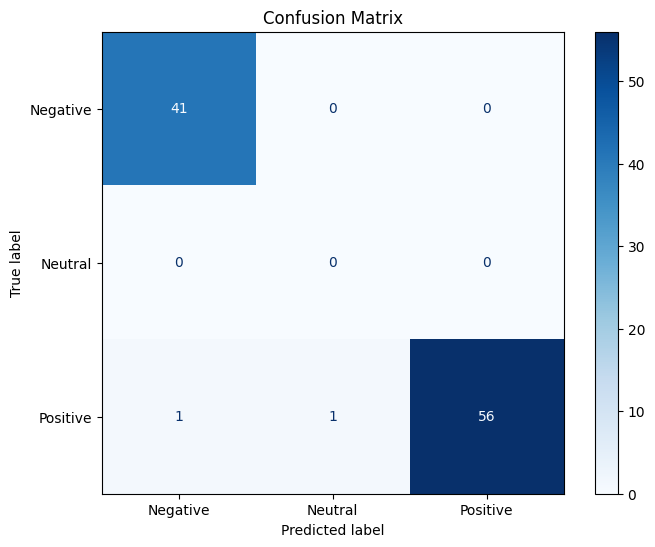

In [9]:
# Get all unique labels
unique_labels = sorted(list(set(y_true + y_pred)))

cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

# 3. Plot the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()

## Analyse failures

In [10]:
# Save failures to a CSV file
failures_df = pd.DataFrame(failures_list)
failures_df.to_csv("model_failures.csv", index=False, quoting=csv.QUOTE_ALL)
print(f"Saved {len(failures_list)} failures to 'model_failures.csv'")

Saved 2 failures to 'model_failures.csv'


### First review in model_failures.csv

-------------------------------------------------------------------------------------------

I enjoy Italian food and great pasta, but I feel like this just wasn't the restaurant for me.

Came here with a group of friends to enjoy dinner and ahead of the visit I scanned the menu and was a little disappointed to see that the menu was what I like to call "one note".

Italy is a beautiful country with a diverse cuisine, but this menu really just hits on the overly heavy dishes typically enjoyed by Americans. I was surprised to see it was nearly absent of center plate, proteins, grilled items and even vegetables, aside from a few salads.

We started with a number of appetizers, almost all of which were fried, including the artichoke hearts, calamari, and arancini. All of them were nicely fried, not greasy and crispy on the outside, but in general, I felt this was pretty expected.

We then ordered pizzas and pasta dishes, and I'll say that the pasta was quite good. I chose the sacchetti with Gorgonzola to was very delicious, with the perfect al dente texture too. All of my dining companions agreed as well. There were other solid pasta choices too, so if this is what you're after, I'd definitely visit. We all also really loved the gluten free pasta with house sausage too, and it was nice that they had this as an option.

The other standout entree was the chicken parmigiana, which had great texture and a delightful tangy tomato sauce that made you want to lick the plate clean.

Pizzas were all tasty too, but after fried apps and pasta, it was tough to really enjoy them.

All in all the food was tasty and great for a group, with wonderful service. Cocktails were def very mid imho, and I did expect better from a restaurant in SF.

-------------------------------------------------------------------------------------------

*Sentiment: Positive*

*Predicted: Negative*

The review seems positive but the model classified it as 'Negative'. Maybe because the text is too long and has some negative views and many "but"s like:

    "I enjoy Italian food and great pasta, but I feel like this just wasn't the restaurant for me."

    "Italy is a beautiful country with a diverse cuisine, but this menu really just hits on the overly heavy dishes typically enjoyed by Americans."

    "All of them were nicely fried, not greasy and crispy on the outside, but in general, I felt this was pretty expected."

    "Pizzas were all tasty too, but after fried apps and pasta, it was tough to really enjoy them."



-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------

### Second review in model_failures.csv

-------------------------------------------------------------------------------------------

This place can get really busy, so plan accordingly. It's tucked away in a small street in San Francisco, best way to get there could be Uber or plan to park your car and block or two away.
French inspired with with a hint of San Francisco local and a dash of Vietnamese.

-------------------------------------------------------------------------------------------
*Sentiment: Positive*

*Predicted: Neutral*

Even though we instructed the model to only reply with "Postivie" or "Negative", it seems like it was forced to respond to "Neutral". Which is expected mistake from a 2B paramters only model.

The writer of the review gave 4 stars, but the review sounds more like a guide than a review, that could be a reason why the model gave it "Neutral".
